# Time Temperature Superposition

This example is written in Python, but the principles could be applied in MATLAB, Excel, or many other software programs.

The first step is to load the relevant libraries.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fmin

Next we load the data file

In [2]:
data = np.loadtxt('char_dat.txt')

Now we need to parse the data file a little bit, here are the first few lines of the file

In [3]:
data [0:2]

array([[ 130.  ,    2.  ,   10.25],
       [   0.  ,    2.25,   10.25]])

The first column gives the temperature, but only when there is a new temperature, otherwise it reads zero.
The second column gives time and the third column gives stiffness.

The following code creates an array of temperatures, then stores the stiffness vs. time data in a 3D array, so that each curve can be related to its associated temperature.

In [4]:
newdata = []
dats = -1
temps = []

for i in xrange(len(data)):
    if data[i,0] != 0:
        newdata.append([(data[i,1],data[i,2])])
        dats += 1
        temps.append(data[i,0])
    else:
        newdata[dats].append((data[i,1],data[i,2]))


Now we plot all the data on the same time-scale.
Viscoelastic data are often plotted on a log-log scale, as we have done here.

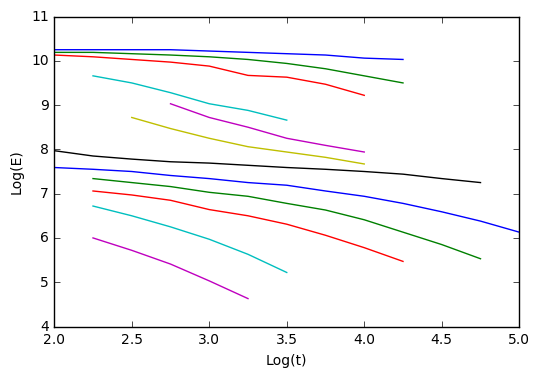

In [5]:
#plot data on same time scale
plt.figure()
for i in newdata:
    plt.plot([x[0] for x in i],[x[1] for x in i])
plt.xlabel('Log(t)')
plt.ylabel('Log(E)')
plt.show()

Now we choose a reference temperature and shift the other data around that temperature.
Some form of least squares optimization could be used to shift the data, but I just shifted it manually.

Note: numerically, it is much better to work with the log() of the data, rather than working with the data directly and then plotting it on a log-scale (that is why my plot is linear, but I am plotting the log() of the data).

We use 150.8 (temps are absolute) as the reference temperature.

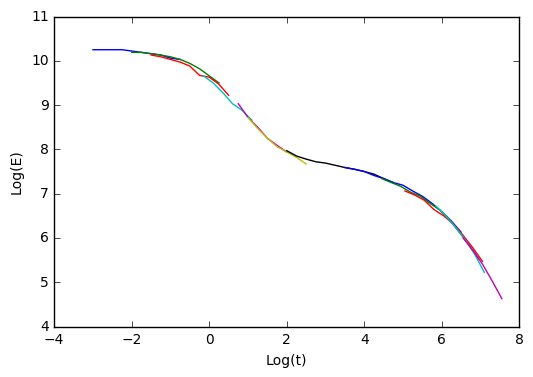

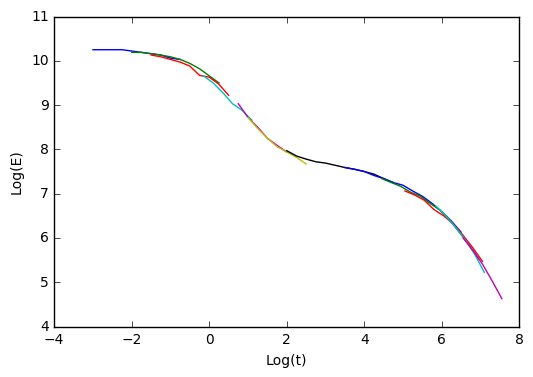

In [7]:
plt.figure()
at = [-5,-4,-3.5,-2.4,-2,-1.5,0,1.5,2.2,2.8,3.6,4.3]
for i in xrange(len(newdata)):
    plt.plot([float(x[0]+at[i]) for x in newdata[i]],[x[1] for x in newdata[i]])
plt.xlabel('Log(t)')
plt.ylabel('Log(E)')
plt.show()

These are pretty closely aligned, so we see that they form one smooth curve over a much larger time scale than our initial data.
Now to be able to predict this full curve at any arbitrary temperature, we need to model the temperature shift using an Arrhenius or Williams-Landel-Ferry model.

Since we are dealing with the log of the data, we can use WLF equation like this:
$$
\log(a_t) = \frac{-C_1(T-T_r)}{C_2 + T-T_r}
$$

In Python I need to give the optimizer some initial guess for $C_1$ and $C_2$, I also calculate $T-T_r$ as its own array to make the calculations simpler, and I build the negative sign into $C_1$. The optimization routine then compares the calculated $\log(a_t)$ values with the manual versions we found earlier.

In [8]:
x0 = [17.4,51.6] #initiial values for optimization
t = np.array(temps)-150.8 #convert absolute temps to relative
a = np.array(at) #manual shift values
def myfunc(x):
    ans = x[0]*t[1:]/(x[1]+t[1:]) #WLF equation
    return sum((a[1:]-ans)**2) #squared difference of manual shift with calculated shift

ans = fmin(myfunc,x0) #optimized constants C_1 and C_2 are in the array ans

Optimization terminated successfully.
         Current function value: 0.137774
         Iterations: 59
         Function evaluations: 115


Now we can plot the temperature shift factor over a range of temperatures and compare them to our manual values

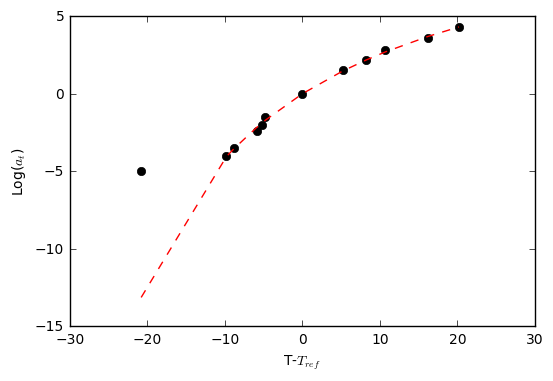

In [9]:
plt.figure()
plt.plot(t,a,'ko')
plt.plot(t,ans[0]*t/(ans[1]+t),'r--')
plt.ylabel(r'Log($a_t$)')
plt.xlabel('T-$T_{ref}$')
plt.show()

We see that for the lowest temperature, our shift factor was not very accurate, this is typical, and if we needed an accurate shift factor in that range we would need to choose a reference temperature closer to that temperature. It is also possible that our manual shift was inaccurate since in that range the two curves are very close.